In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [7]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.0
Python 버전: 3.10.12


#### CUDA 사용 및 EarlyStopping 설정

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


맥북 M2 MAX는 NVIDEA GPU를 사용하지 않아 CUDA 지원 안 함

#### 모델 저장

In [3]:
def saveModel():
    torch.save(model.state_dict(), 'model_ar1.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [5]:
# 하이퍼파라미터 설정
length = 24            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
hidden_size1 = 48      # 은닉층 1 크기
hidden_size2 = 24      # 은닉층 2 크기
hidden_size3 = 12      # 은닉층 3 크기
hidden_size4 = 6       # 은닉층 4 크기
learning_rate = 1e-6   # 학습률
epoch = 400
trainrun = 50          # 생성할 학습 데이터 시퀀스의 수 
testrun = 25           # 생성할 평가 데이터 시퀀스의 수 
validrun = 25          # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0, 0.25, 0.5, 0.75, 0.95별로 생성)
phi1 = np.array([np.repeat(0,8),
                 np.repeat(0.25,8),
                 np.repeat(0.5,8),
                 np.repeat(0.75,8),
                 np.repeat(0.95,8)])
phi1 = np.concatenate(phi1)

# 변화율 크기 (= 이상상태 포함 정도, psi) * 논문과 수치가 약간 변동이 있음
psi1 = np.array([0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,])

# 공정의 수준 변화율 (delta)
de1 = np.array([0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,])

# 공정의 분산 변화율 (gamma)
ga = np.array([1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,])             0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
   

#### 시계열 데이터 생성

In [6]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.array(np.repeat(0, length), dtype=np.float64)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = ar1 * x[i - 1] + e[i]                        # 각 시점에서의 값은 이전 시점의 값에 자기상관 계수 ar1을 곱한 것과 현재 시점의 노이즈를 더한 값으로 설정
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # psi 시점 이후에는 각 에러 항에 gamma 값을 곱하여 에러 항의 변동성을 조절 
            e[i] = gamma * e[i]
            x[i] = ar1 * x[i-1] + e[i]
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i in range(len(phi1)):
        y[i]= ar(phi1[i], de1[i], ga[i], psi1[i], length, run)

    return y


# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            # 생성된 훈련용 데이터를 적절한 형태로 재배열

# 레이블 생성 및 변형
train_y =  [np.repeat(0,trainrun),np.repeat(1,trainrun*7),      # 관리상태(1가지)는 0, 이상상태(7가지)는 1로 가정
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),]
train_y =  np.concatenate(train_y)
train_y = train_y.reshape(2000,1)                               # 최종 레이블 배열의 형태를 조정 (학습용 데이터 세트 2000개)

# 평가용 시계열 데이터
# 데이터 생성 및 변형
test_x = totaldat(run = testrun, length = length)
test_x = test_x.reshape(testrun*len(phi1),length)

# 레이블 생성 및 변형
test_y = [np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),]
test_y = np.concatenate(test_y)
test_y = test_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (평가용 데이터 세트 1000개)

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# 레이블 생성 및 변형
valid_y = [np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),]
valid_y = np.concatenate(valid_y)
valid_y = valid_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (검증용 데이터 세트 1000개)


# PyTorch 텐서로 변환 및 장치 할당
train_x = torch.FloatTensor(train_x).to(device)
train_y = torch.FloatTensor(train_y).to(device)
test_x = torch.FloatTensor(test_x).to(device)
test_y = torch.FloatTensor(test_y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)

# DataLoader 설정
trainset = TensorDataset(train_x, train_y)                        # 데이터와 레이블 쌍을 포함하는 데이터셋 생성
trainloader = DataLoader(trainset, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
testset = TensorDataset(test_x, test_y)
testloader = DataLoader(testset,shuffle = False)                  # 학습 및 검증에서는 데이터 순서 유지
validset = TensorDataset(valid_x, valid_y)
validloader = DataLoader(validset,shuffle = False)

#### 모델 구조

In [6]:
class NeuralNetwork(nn.Module):
    # 클래스 초기화
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(NeuralNetwork, self).__init__()
        self.device = device                                          
        self.hidden_size = hidden_size                                # RNN 모델의 은닉층 크기 
        self.num_layers = num_layers                                  # RNN 모델의 층 개수
        
        # 기본 RNN 레이어 생성
        self.rnn = nn.RNN(input_size= input_size,
                          hidden_size = hidden_size1,
                          num_layers = num_layers,
                          nonlinearity= "relu",                       # 활성화 함수로 relu를 사용
                          batch_first= True)                          # 입력 텐서의 첫 번째 차원이 배치 크기임을 나타냄
        
        # 완전 연결 레이어 (여러 레이어를 연속적으로 적용할 수 있게 하기 위해 nn.Sequential을 사용)
        self.fc = nn.Sequential(nn.Linear(hidden_size,hidden_size2),  # 선형 레이어
                                nn.GELU(),                            # GELU 활성화 함수
                                nn.Linear(hidden_size2,hidden_size3),
                                nn.GELU(),
                                nn.Linear(hidden_size3,hidden_size4),
                                nn.GELU(),
                                nn.Linear(hidden_size4,1),
                                nn.Sigmoid()                          # 시그모이드 활성화함수를 사용해 출력을 [0, 1] 범위로 조정
                                )

    # 순전파 (forward)
    def forward(self, x):
        # 초기 hidden state 설정
        h0 = torch.zeros(x.size()[0], self.hidden_size).to(device)    # 각 배치에 대한 초기 은닉층을 0으로 설정 (= RNN의 첫 번째 시점에서 이전 상태가 없음을 의미)
        
        # RNN 레이어 실행
        out, _ = self.rnn(x, h0)                                      # 입력 데이터 x와 초기 은닉층 h0를 RNN 층에 전달함. out: RNN의 마지막 레이어로부터 나온 output feature 를 반환 (hn: hidden state를 반환)
        
        # 데이터 재구성 및 완전 연결 레이어 실행
        out = out.reshape(out.shape[0], -1)                           # many to many 전략 : 시퀀스의 각 타임 스텝에 대응하는 출력 생성 
        out = self.fc(out)                                            # out을 재구성하여 모든 시간 단계의 출력을 하나의 벡터로 평탄화하고 완전 연결 레이어를 통해 최종 예측값을 계산
        
        return out


# 모델 초기화
model = NeuralNetwork(input_size = length, hidden_size = hidden_size1, num_layers = 1, device = device).to(device)

# Optimizer 설정
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 손실 함수 설정
criterion = nn.MSELoss()

# 손실 기록을 위한 리스트 초기화
loss_ = []                                                            # 훈련 과정에서의 손실값 기록
n = len(trainloader)
valoss_ = []                                                          # 검증 과정에서의 손실값 기록
logger = {"train_loss": list(),
          "validation_loss": list()
         }

#### 학습 (Training)

epoch 1
train loss : 0.18339458154141902, validation loss : 0.18287986285984517
Validation loss decreased (inf --> 0.182880).  Saving model ...
epoch 2
train loss : 0.18297171778976917, validation loss : 0.18244530859589578
Validation loss decreased (0.182880 --> 0.182445).  Saving model ...
epoch 3
train loss : 0.18253963969647882, validation loss : 0.18200153190394244
Validation loss decreased (0.182445 --> 0.182002).  Saving model ...
epoch 4
train loss : 0.18209899440594016, validation loss : 0.18154845437034967
Validation loss decreased (0.182002 --> 0.181548).  Saving model ...
epoch 5
train loss : 0.1816493692368269, validation loss : 0.1810861652120948
Validation loss decreased (0.181548 --> 0.181086).  Saving model ...
epoch 6
train loss : 0.1811899957321584, validation loss : 0.18061375958969195
Validation loss decreased (0.181086 --> 0.180614).  Saving model ...
epoch 7
train loss : 0.18072123059949702, validation loss : 0.1801316195407084
Validation loss decreased (0.180614

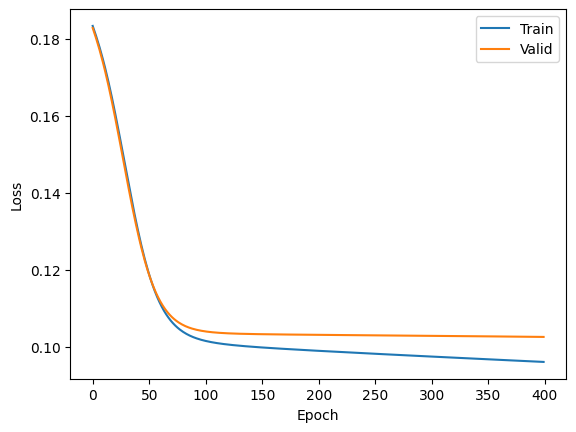

In [7]:
def training(epochs) :
    # epoch 별 훈련 및 검증 루프 (trainloader를 반복하여 모델 훈련시키고, validloader를 사용해 모델의 성능 검증)
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0
        total = 0

        # 훈련 과정
        for data in trainloader:
            model.train()
            inputs, outputs = data
            optimizer.zero_grad()                                                     # Optimizer Gradient를 0으로 초기화. 이는 각 미니배치마다 Gradient가 누적되는 것을 방지
            predicted_outputs = model(inputs)                                         # 모델을 사용하여 입력 데이터에 대한 예측값을 계산
            train_loss = criterion(predicted_outputs, outputs)                        # 계산된 예측값과 실제 레이블 간의 손실을 계산
            train_loss.backward()                                                     # 손실에 대한 역전파를 수행하여 Gradient를 계산
            optimizer.step()                                                          # 계산된 Gradient를 사용하여 모델 매개변수를 업데이트
            running_train_loss += train_loss.item()                                   # track the loss value
        loss_.append(running_train_loss / n)
        
        # 검증 과정
        with torch.no_grad():                                                         # Gradient 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 향상 
            model.eval()
            for data in validloader:
                inputs, outputs = data
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs)

                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs,1)
                running_vall_loss += val_loss.item()
                total += outputs.size(0)
                val_loss_value = running_vall_loss/len(validloader)
        valoss_.append(val_loss_value)

        avgtrainloss = np.mean(loss_)
        avgvalidloss = np.mean(valoss_)
        print('epoch', epoch + 1)
        print(f'train loss : {avgtrainloss}, validation loss : {avgvalidloss}')
        
        # EarlyStopping
        early_stopping(avgvalidloss, model)                                           # 검증 손실을 기준으로 조기 종료 조건 확인
        if early_stopping.early_stop:                                                 # 조건 만족 시 조기 종료
            break

    # 모델 저장    
    saveModel()
training(epochs = epoch)


# 손실 시각화
plt.plot(loss_)
plt.plot(valoss_)
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 평가 (Evaluation)

In [13]:
def evaluation(dataloader):
  # 초기화
  predictions = torch.tensor([], dtype=torch.float64,device = device)  # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float64, device = device)      # 실제값을 저장하는 텐서.

  # 평가 모드 설정
  with torch.no_grad():
    model.eval()                                                       # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    # 데이터 로더를 통한 반복
    for data in dataloader:
        inputs, values = data
        outputs = model(inputs)

        # 예측값 및 실제값 저장
        predictions = torch.cat((predictions, outputs), 0)             # cat함수를 통해 예측값을 누적.
        actual = torch.cat((actual, values), 0)                        # cat함수를 통해 실제값을 누적.
  
  # CPU로 이동 및 NumPy 배열 변환
  predictions =predictions.to(device= "cpu")
  predictions = predictions.numpy()                                    # 넘파이 배열로 변경.
  actual = actual.to(device= "cpu")
  actual = actual.numpy()                                              # 넘파이 배열로 변경.
  
  # RMSE 계산
  rmse = np.sqrt(mean_squared_error(predictions, actual))              # sklearn을 이용해 RMSE를 계산.

  return rmse,actual,predictions

preds = []
for i in tqdm(range(1000)):
  test_rmse, actual, pred = evaluation(testloader)
  preds.append(pred)

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [9]:
test_rmse

0.32045842141585223

In [10]:
actual

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
pred

array([[0.79414427],
       [0.79857379],
       [0.75345188],
       [0.69617122],
       [0.74821973],
       [0.69831884],
       [0.81406605],
       [0.71896827],
       [0.81185931],
       [0.81028706],
       [0.76456857],
       [0.72057891],
       [0.67779344],
       [0.6953336 ],
       [0.71612912],
       [0.8021335 ],
       [0.71617234],
       [0.91390908],
       [0.81437641],
       [0.72651291],
       [0.81546825],
       [0.73143101],
       [0.81274134],
       [0.79042393],
       [0.70673347],
       [0.89656335],
       [0.8965947 ],
       [0.71331888],
       [0.87819546],
       [0.85288715],
       [0.82518595],
       [0.89592975],
       [0.85329705],
       [0.9303776 ],
       [0.81652856],
       [0.72765625],
       [0.94350713],
       [0.81115413],
       [0.82701367],
       [0.90527886],
       [0.90483165],
       [0.8478567 ],
       [0.85520297],
       [0.8760823 ],
       [0.86505413],
       [0.95100522],
       [0.73236126],
       [0.934

In [12]:
pred.shape

(1000, 1)

#### 실제값과 예측값 시각화

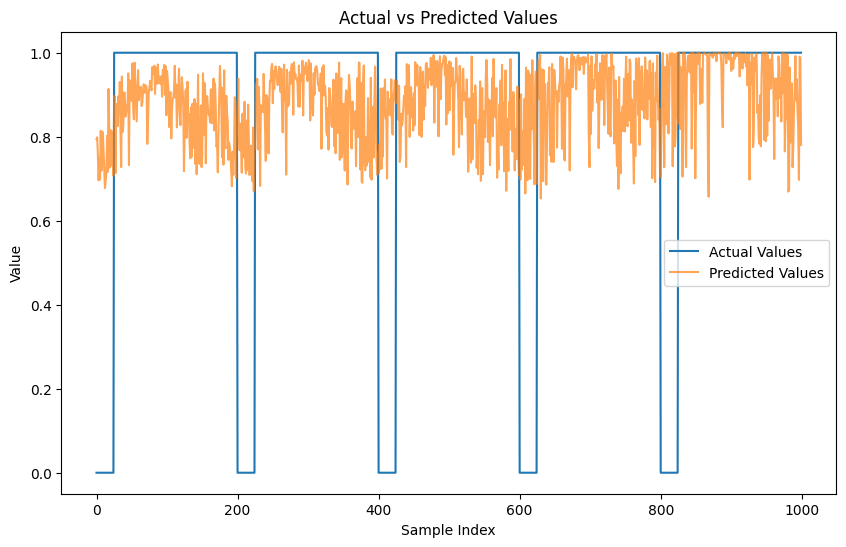

In [13]:
# 실제 값과 예측값을 시각화하는 코드
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(actual, label='Actual Values')  # 실제 값 그래프
plt.plot(pred, label='Predicted Values', alpha=0.7)  # 예측 값 그래프, 투명도를 주어 구분하기 쉽게 함
plt.title('Actual vs Predicted Values')  # 그래프 제목
plt.xlabel('Sample Index')  # x축 라벨
plt.ylabel('Value')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 표시

In [4]:
model = torch.load(f'../model_b_ar1_l24_v5.pt')

In [5]:
model

OrderedDict([('rnn.weight_ih_l0',
              tensor([[ 0.1039,  0.0838, -0.1345,  ...,  0.1262,  0.1138, -0.0422],
                      [-0.0543, -0.0084, -0.0415,  ..., -0.0728, -0.1225,  0.0680],
                      [ 0.0125,  0.0145, -0.0224,  ..., -0.0779, -0.1662, -0.0740],
                      ...,
                      [-0.0314,  0.1238,  0.0245,  ..., -0.1601, -0.0749, -0.0538],
                      [-0.0404, -0.0957, -0.0752,  ..., -0.0707,  0.1202,  0.0264],
                      [-0.0030, -0.0952,  0.1127,  ...,  0.0591,  0.0041,  0.2346]])),
             ('rnn.weight_hh_l0',
              tensor([[ 0.1060,  0.0003, -0.0118,  ..., -0.1039,  0.0170, -0.0597],
                      [-0.0659,  0.1109,  0.0839,  ...,  0.0375, -0.1409,  0.0122],
                      [ 0.0917, -0.0679,  0.0214,  ...,  0.0198, -0.1272,  0.1387],
                      ...,
                      [-0.0450,  0.1325,  0.0458,  ..., -0.1018, -0.1425,  0.0820],
                      [-0.0392, -0.

#### ARL0 구하기

In [51]:
np.random.seed(1)

l = 24

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = ar * x[i-1] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [57]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)

                if output[0] > cl :

                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

In [ ]:
def arl0(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)

                if output[0] > cl :

                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

In [ ]:
arl0(ar,delta,gamma, run, length,cl)

#### ARL1 구하기

In [88]:
def arl1(ar,run,length,cl):
    a5 = arl(ar, 0.5, 1, run, length, cl)
    a1 = arl(ar, 1, 1, run, length, cl)
    a2 = arl(ar, 2, 1, run, length, cl)
    a3 = arl(ar, 3, 1, run, length, cl)
    b5 = arl(ar, 0.5, 1.5,run, length, cl)
    b1 = arl(ar, 1, 1.5, run, length, cl)
    b2 = arl(ar, 2, 1.5, run, length, cl)
    b3 = arl(ar, 3, 1, run, length, cl)
    c1 = arl(ar, 0, 1.5, run, length, cl)
    c2 = arl(ar, 0, 2, run, length, cl)
    c3 = arl(ar, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

### phi = 0 일 때

#### ARL0 (threshold 임의 추정)

In [95]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.94)

100%|██████████| 10000/10000 [02:56<00:00, 56.68it/s]


312.3063

In [89]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.945)

100%|██████████| 10000/10000 [03:58<00:00, 41.88it/s]


423.4017

In [90]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9425)

100%|██████████| 10000/10000 [03:22<00:00, 49.37it/s]


356.1153

In [91]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9437)

100%|██████████| 10000/10000 [03:42<00:00, 44.90it/s]


391.1835

In [92]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9431)

100%|██████████| 10000/10000 [03:34<00:00, 46.72it/s]


375.4041

In [93]:
arl(ar = 0, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9428)

100%|██████████| 10000/10000 [03:30<00:00, 47.40it/s]


370.5614

#### ARL1

In [98]:
arl1(ar=0, run=10000, length=1000, cl=0.9428)

100%|██████████| 10000/10000 [00:11<00:00, 893.93it/s]

0.5: 34.1666, 1:10.6933,2:4.2828,3:2.4727
0.5:15.2481,1:8.4831,2:4.0109,3:2.484
1.5:36.467,2:16.5166,3:7.9349


### phi = 0.25 일 때

#### ARL0 (threshold 임의 추정)

In [96]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95)

100%|██████████| 10000/10000 [02:56<00:00, 56.67it/s]


310.5583

In [97]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.96)

100%|██████████| 10000/10000 [05:20<00:00, 31.23it/s]


564.8062

In [99]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9525)

100%|██████████| 10000/10000 [03:29<00:00, 47.74it/s]


365.472

In [100]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9528)

100%|██████████| 10000/10000 [03:31<00:00, 47.17it/s]


370.573

#### ARL1

In [102]:
arl1(ar=0.25, run=10000, length=1000, cl=0.9528)

100%|██████████| 10000/10000 [00:12<00:00, 830.67it/s]

0.5: 42.4329, 1:13.1817,2:5.039,3:2.8608
0.5:18.391,1:10.1903,2:4.7964,3:2.8483
1.5:43.9206,2:19.9373,3:9.7736


### phi = 0.5 일 때

#### ARL0 (threshold 임의 추정)

In [103]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.96)

100%|██████████| 10000/10000 [01:47<00:00, 93.33it/s]


182.8035

In [104]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.97)

100%|██████████| 10000/10000 [03:31<00:00, 47.23it/s]


372.183

In [107]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9685)

100%|██████████| 10000/10000 [03:08<00:00, 53.19it/s]


330.7466

In [108]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.969)

100%|██████████| 10000/10000 [03:15<00:00, 51.21it/s]


339.638

In [109]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9695)

100%|██████████| 10000/10000 [03:24<00:00, 48.80it/s]


355.9155

In [110]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9697)

100%|██████████| 10000/10000 [03:26<00:00, 48.32it/s]


360.8606

In [111]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9698)

100%|██████████| 10000/10000 [03:29<00:00, 47.72it/s]


364.4805

In [112]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9699)

100%|██████████| 10000/10000 [03:30<00:00, 47.62it/s]


368.4389

#### ARL1

In [113]:
arl1(ar=0.5, run=10000, length=1000, cl=0.97)

100%|██████████| 10000/10000 [00:13<00:00, 723.01it/s]

0.5: 59.1936, 1:18.5505,2:6.3225,3:3.4699
0.5:25.0616,1:13.7797,2:6.1389,3:3.4785
1.5:55.233,2:25.8266,3:12.9047


### phi = 0.75 일 때

#### ARL0 (threshold 임의 추정)

In [114]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.98)

100%|██████████| 10000/10000 [01:15<00:00, 132.35it/s]


125.8499

In [115]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99)

100%|██████████| 10000/10000 [03:22<00:00, 49.47it/s]


353.9779

In [116]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9925)

100%|██████████| 10000/10000 [04:48<00:00, 34.60it/s]


509.4377

In [117]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9915)

100%|██████████| 10000/10000 [04:08<00:00, 40.17it/s]


436.7106

In [118]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9912)

100%|██████████| 10000/10000 [03:49<00:00, 43.58it/s]


417.2016

In [119]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9905)

100%|██████████| 10000/10000 [03:35<00:00, 46.49it/s]


380.2168

In [121]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9903)

100%|██████████| 10000/10000 [03:24<00:00, 48.90it/s]


370.2725

#### ARL1

In [122]:
arl1(ar=0.75, run=10000, length=1000, cl=0.9903)

100%|██████████| 10000/10000 [00:43<00:00, 229.47it/s]

0.5: 90.3146, 1:31.6137,2:9.1701,3:4.7853
0.5:39.1702,1:22.4344,2:9.2316,3:4.7507
1.5:79.5065,2:40.6724,3:21.0136


### phi = 0.95 일 때

#### ARL0 (threshold 임의 추정)

In [123]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.995)

100%|██████████| 10000/10000 [02:15<00:00, 73.80it/s]


84.0806

In [124]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.996)

100%|██████████| 10000/10000 [11:25<00:00, 14.58it/s] 


92.2365

In [125]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.997)

100%|██████████| 10000/10000 [01:00<00:00, 164.23it/s]


103.1307

In [126]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.998)

100%|██████████| 10000/10000 [01:13<00:00, 136.08it/s]


123.9279

In [127]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.999)

100%|██████████| 10000/10000 [23:42<00:00,  7.03it/s]  


165.144

In [128]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9999)

100%|██████████| 10000/10000 [03:41<00:00, 45.24it/s]


404.3203

In [129]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9995)

100%|██████████| 10000/10000 [02:07<00:00, 78.22it/s]


223.0914

In [130]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9997)

100%|██████████| 10000/10000 [02:37<00:00, 63.67it/s]


273.3544

In [131]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99985)

100%|██████████| 10000/10000 [03:21<00:00, 49.71it/s]


354.469

In [132]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99987)

100%|██████████| 10000/10000 [03:29<00:00, 47.77it/s]


368.2834

In [133]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99988)

100%|██████████| 10000/10000 [03:38<00:00, 45.84it/s]


384.7888

In [134]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.999875)

100%|██████████| 10000/10000 [03:32<00:00, 47.07it/s]


374.5534

In [135]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.999873)

100%|██████████| 10000/10000 [03:27<00:00, 48.22it/s]


366.579

In [137]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.999874)

100%|██████████| 10000/10000 [50:00<00:00,  3.33it/s]  


378.8789

In [138]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998735)

100%|██████████| 10000/10000 [03:27<00:00, 48.21it/s]


376.3259

In [139]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998734)

100%|██████████| 10000/10000 [03:34<00:00, 46.69it/s]


376.1174

In [140]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998733)

100%|██████████| 10000/10000 [03:33<00:00, 46.88it/s]


375.5979

In [141]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998732)

100%|██████████| 10000/10000 [03:30<00:00, 47.54it/s]


377.4521

In [142]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998731)

100%|██████████| 10000/10000 [03:25<00:00, 48.64it/s]


371.4345

In [146]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99987305)

100%|██████████| 10000/10000 [03:35<00:00, 46.49it/s]


375.0694

In [144]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9998737)

100%|██████████| 10000/10000 [03:26<00:00, 48.32it/s]


370.9911

#### ARL1

In [147]:
arl1(ar=0.95, run=10000, length=1000, cl=0.9998731)

100%|██████████| 10000/10000 [00:38<00:00, 262.87it/s]

0.5: 155.3962, 1:71.3895,2:17.5483,3:6.9382
0.5:85.0779,1:49.9915,2:19.0496,3:6.9832
1.5:146.6575,2:90.3462,3:55.9962
